In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm,tqdm_notebook
import copy
import time
import datetime
import gc
from typing import List
from typing import Any
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from collections import Counter
from collections import defaultdict

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn import linear_model
from sklearn.svm import NuSVR, SVR

import lightgbm as lgb
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

In [2]:
import random
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(4396)

## data building

In [4]:
####Process_Table 是最终结果
####Phase_Table 是每个步骤的结果
####Parameters_Table 是每个步骤的参数
####我们预测的是 PHASE_RESULT_STATE

compiled_train = []
for train_file in tqdm(os.listdir("./INSPEC_Data/INSPEC_train/")):
    temp_process = pd.read_excel("./INSPEC_Data/INSPEC_train/"+train_file,sheet_name="Process_Table")
    temp_phase = pd.read_excel("./INSPEC_Data/INSPEC_train/"+train_file,sheet_name="Phase_Table")
    temp_paramters = pd.read_excel("./INSPEC_Data/INSPEC_train/"+train_file,sheet_name="Parameters_Table")
    
    temp = temp_paramters.merge(temp_phase,on=["ID_F_PHASE","ID_F_PHASE_S"],how="left")
    temp = temp.merge(temp_process,on=["ID_F_PROCESS"],how="left")
    ###按产品和加工步骤排序
    temp = temp.sort_values(["ID_F_PROCESS","ID_F_PHASE_S"])
    
    compiled_train.append(temp)
reduce_train = pd.concat(compiled_train)
#reduce_train.to_csv("./train.csv",index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [36:56<00:00, 34.64s/it]


## preprocessing

In [3]:
#### upper,lower limit only useful for 10_phase
###all PARAMETER_RESULT_STATE==1 in test-data....
train = pd.read_csv("./train.csv")
test_4_part = pd.read_csv("./INSPEC_Data/INSPEC_validation/validation_predict_4.csv")
test_11_part = pd.read_csv("./INSPEC_Data/INSPEC_validation/validation_predict_11.csv")

In [4]:
train.rename(columns={"ID_F_PROCESS":"Product_ID"},inplace=True)

In [5]:
train["RESULT_VALUE"].fillna(0,inplace=True)
test_4_part["RESULT_VALUE"].fillna(0,inplace=True)
test_11_part["RESULT_VALUE"].fillna(0,inplace=True)

train["LOWER_LIMIT"].fillna(0,inplace=True)
test_4_part["LOWER_LIMIT"].fillna(0,inplace=True)
test_11_part["LOWER_LIMIT"].fillna(0,inplace=True)

train["UPPER_LIMIT"].fillna(9999,inplace=True)
test_4_part["UPPER_LIMIT"].fillna(9999,inplace=True)
test_11_part["UPPER_LIMIT"].fillna(9999,inplace=True)

train["AXIS"].fillna(0,inplace=True)
test_4_part["AXIS"].fillna(0,inplace=True)
test_11_part["AXIS"].fillna(0,inplace=True)

train["SIDE"].fillna("NAN",inplace=True)
test_4_part["SIDE"].fillna("NAN",inplace=True)
test_11_part["SIDE"].fillna("NAN",inplace=True)

drop_cols = ["PARAMETER_RESULT_STATE","PHASE_RESULT_STATE","RESULT_STRING","LOWER_LIMIT","UPPER_LIMIT"]

train.drop([x for x in drop_cols if x in train],axis=1,inplace=True)
test_4_part.drop([x for x in drop_cols if x in test_4_part],axis=1,inplace=True)
test_11_part.drop([x for x in drop_cols if x in test_11_part],axis=1,inplace=True)

## fixed answers

In [6]:
#### for axis,side?
for col in train:
    if train[col].dtype=="object" and col!="PROCESS_RESULT_STATE":
        train[col].fillna("NAN",inplace=True)
        test_4_part[col].fillna("NAN",inplace=True)
        test_11_part[col].fillna("NAN",inplace=True)
    elif col!="PROCESS_RESULT_STATE":
        train[col].fillna(0,inplace=True)
        test_4_part[col].fillna(0,inplace=True)
        test_11_part[col].fillna(0,inplace=True)

In [7]:
id_count = test_4_part["Product_ID"].value_counts()

In [8]:
answer_map = {}
for id in id_count[id_count==1].index.tolist():
    answer_map[id] = 1
###all data lost...
for id in id_count[id_count==3].index.tolist():
    answer_map[id] = 1    
for id in id_count[id_count==4].index.tolist():
    answer_map[id] = 1
for id in id_count[id_count==5].index.tolist():
    answer_map[id] = 1
for id in id_count[id_count==8].index.tolist():
    answer_map[id] = 1

In [9]:
answer_map_ = {}
id_count = test_11_part["Product_ID"].value_counts()
for id in id_count[id_count<=10].index.tolist():
    answer_map_[id]=1

In [10]:
def find_fail_ids(count,low=False):
    temp_ = test_4_part[test_4_part.Product_ID.isin(id_count[id_count==count].index.tolist())]
    group_names = temp_["PRODUCTGROUP_NAME"].unique().tolist()
    fail_ids = []
    
    for group in group_names:
        temp = temp_[temp_.PRODUCTGROUP_NAME==group]
        if len(temp)>len(temp_)*0.2:
            compiled_sample = []
            for i_,(id,sample) in enumerate(temp.groupby("Product_ID")):
                new_dict = {}
                new_dict["Product_ID"] = sample.iloc[0]["Product_ID"]
                for i,(index,row) in enumerate(sample.sort_values(["ID_F_PHASE_S","ID_F_PARAMETER_S"]).iterrows()):
                    new_dict["row_"+str(i)+"_RESULT_VALUE"] = row["RESULT_VALUE"]
                compiled_sample.append(pd.DataFrame(new_dict,index=[i_]))
            compiled_sample = pd.concat(compiled_sample)

            fail_id = []
            for col in compiled_sample:
                if col!="Product_ID":
                    mean_value = compiled_sample[col].median()
                    result = np.abs(compiled_sample[col]-mean_value)/mean_value>0.1
                    if low==True:
                        fail_id = list(set(fail_id)|set(result[result==True].index.tolist()))
                    else:
                        if (result==True).sum()<len(result)*0.1:
                            fail_id = list(set(fail_id)|set(result[result==True].index.tolist()))
            fail_id = [compiled_sample["Product_ID"].values[i] for i in fail_id]
            #print(len(fail_id))
            fail_ids = list(set(fail_ids)|set(fail_id))
    return fail_ids

In [11]:
fail_ids = list(set(find_fail_ids(5,low=True))|set(find_fail_ids(8,low=True)))

In [12]:
for id in fail_ids:
    answer_map[id] = 2

In [13]:
test_4_part.shape,len(test_4_part["Product_ID"].unique())

((97509, 10), 3721)

In [14]:
test_4_part = test_4_part[~test_4_part.Product_ID.isin(list(answer_map.keys()))]

In [15]:
test_4_part.shape,len(test_4_part["Product_ID"].unique())

((94267, 10), 3029)

In [16]:
test_11_part.shape,len(test_11_part["Product_ID"].unique())

((161757, 10), 3784)

In [17]:
test_11_part = test_11_part[~test_11_part.Product_ID.isin(list(answer_map_.keys()))]

In [18]:
test_11_part.shape,len(test_11_part["Product_ID"].unique())

((156776, 10), 3285)

In [19]:
train.head()

,ID_F_PHASE,RESULT_VALUE,AXIS,SIDE,ID_F_PHASE_S,ID_F_PARAMETER_S,Product_ID,PHASE_NAME,PROCESS_RESULT_STATE,TYPE_NUMBER,PRODUCTGROUP_NAME
0,ESRGBG,16.70,1.0,A,0,1,CBEOA,UU9,1.0,jQU90011WUh,Vp3AaLm
1,ESRGBG,16.70,4.0,A,0,4,CBEOA,UU9,1.0,jQU90011WUh,Vp3AaLm
2,ESRGBG,16.70,6.0,A,0,6,CBEOA,UU9,1.0,jQU90011WUh,Vp3AaLm
3,ESRGBG,16.64,1.0,B,0,7,CBEOA,UU9,1.0,jQU90011WUh,Vp3AaLm
4,ESRGBG,16.64,4.0,B,0,10,CBEOA,UU9,1.0,jQU90011WUh,Vp3AaLm


In [20]:
res = pd.read_csv("./INSPEC_result.csv")

In [21]:
answer_map_ = {}

In [22]:
res = pd.concat([res,
          pd.DataFrame({
              'id':list(answer_map_.keys()),
              'label':list(answer_map_.values()),
          })]).reset_index(drop=True)

## feature extraction

In [21]:
def feature_extract(df,phases=10,test_set=False):
    all_features = {}
    all_features["product_id"] = df["Product_ID"].iloc[0]
    all_features["type_number"] = df["TYPE_NUMBER"].iloc[0]
    all_features["PRODUCTGROUP_NAME"] = df["PRODUCTGROUP_NAME"].iloc[0]
    
    if test_set==False:
        all_features["target"] = df["PROCESS_RESULT_STATE"].iloc[0]
    
    """helper functions"""
    def value_statics(df,col,prefix=""):
        feature = {}
        feature[prefix+col+"_max"] = df[col].max() if len(df)>0 else 0
        feature[prefix+col+"_min"] = df[col].min() if len(df)>0 else 0
        feature[prefix+col+"_mean"] = df[col].mean() if len(df)>0 else 0
        feature[prefix+col+"_median"] = df[col].median() if len(df)>0 else 0
        if col=="RESULT_VALUE":
            feature[prefix+col+"_5p"] = np.percentile(df[col],5) if len(df)>0 else 0
        return feature
    
    for phase in range(phases):
    #for phase,phase_session in enumerate(df.groupby("ID_F_PHASE_S",sort=True)):
        phase_session = df[df.ID_F_PHASE_S==phase]
        phase = str(phase)
        all_features["phase_"+phase+"_count"] = len(phase_session)
        all_features.update(value_statics(phase_session,"RESULT_VALUE",prefix="phase_"+phase))
        
    temp = df[df.ID_F_PHASE_S<3]
    max_seq = temp["ID_F_PARAMETER_S"].max()
    min_seq = temp["ID_F_PARAMETER_S"].min()
    all_features["length_equal_sequence_dis"] = int((max_seq-min_seq)+1==len(temp))
    all_features["ID_F_PARAMETER_S_max"] = max_seq
    all_features["ID_F_PARAMETER_S_min"] = min_seq
    all_features["ID_F_PARAMETER_S_str"] = str(int(max_seq))+"_"+str(int(min_seq))
    all_features["type_s_str"] = all_features["type_number"]+"_"+all_features["ID_F_PARAMETER_S_str"]
    all_features["group_s_str"] = all_features["PRODUCTGROUP_NAME"]+"_"+all_features["ID_F_PARAMETER_S_str"]
    if phases>3:
        temp = df[df.ID_F_PHASE_S>3]
        max_seq = temp["ID_F_PARAMETER_S"].max() if len(temp)>0 else 0
        min_seq = temp["ID_F_PARAMETER_S"].min() if len(temp)>0 else 0
        all_features["post_length_equal_sequence_dis"] = int((max_seq-min_seq)+1==len(temp)) if len(temp)>0 else 0
        all_features["post_ID_F_PARAMETER_S_max"] = max_seq if len(temp)>0 else 0
        all_features["post_ID_F_PARAMETER_S_min"] = min_seq if len(temp)>0 else 0
        all_features["post_type_s_str"] = all_features["type_number"]+"_"+all_features["post_ID_F_PARAMETER_S_str"]
        all_features["post_group_s_str"] = all_features["PRODUCTGROUP_NAME"]+"_"+all_features["post_ID_F_PARAMETER_S_str"]
    return all_features

In [22]:
def bin_encoding(train,test,features,bins=None):
    if bins is None:
        bins = [20]*len(features)
    feature_names = []
    bin_counts = defaultdict(lambda:10)
    for feature,bin_ in zip(features,bins):
        bin_counts[feature] = bin_
    for fea in features:
        try:
            if fea in train:
                n_bins = bin_counts[fea]
                if n_bins:
                    bins = np.unique(train[fea].quantile(np.linspace(0,1,n_bins)).values)
                    for df in [train,test]:
                        n_bins = bin_counts[fea]
                        df[fea+"_binned"] = pd.cut(
                            df[fea],bins=bins,duplicates="drop"
                        ).cat.codes
                    feature_names.append(fea+"_binned")
        except:
            print(fea)
    return train,test,feature_names

In [23]:
def group_statics(data,features):
    for col in features:
        #data[col+"_group_to_mean"] = data[col]-data.groupby("PRODUCTGROUP_NAME")[col].transform("mean")
        data[col+"_group_to_mean_rate"] = data[col]/(data.groupby("PRODUCTGROUP_NAME")[col].transform("mean")+1e-2)
        #data[col+"_group_to_median"] = data[col]-data.groupby("PRODUCTGROUP_NAME")[col].transform("median")
        data[col+"_group_to_median_rate"] = data[col]/(data.groupby("PRODUCTGROUP_NAME")[col].transform("median")+1e-2)
        #data[col+"_group_to_min"] = data[col]-data.groupby("PRODUCTGROUP_NAME")[col].transform("min")
        data[col+"_group_to_min_rate"] = data[col]/(data.groupby("PRODUCTGROUP_NAME")[col].transform("min")+1e-2)
        #data[col+"_group_to_max_rate"] = data[col]/(data.groupby("PRODUCTGROUP_NAME")[col].transform("max")+1e-2)
    return data

In [24]:
def type_statics(data,features):
    for col in features:
        #data[col+"_type_to_mean"] = data[col]-data.groupby("type_number")[col].transform("mean")
        data[col+"_type_to_mean_rate"] = data[col]/(data.groupby("type_number")[col].transform("mean")+1e-2)
        #data[col+"_type_to_median"] = data[col]-data.groupby("type_number")[col].transform("median")
        data[col+"_type_to_median_rate"] = data[col]/(data.groupby("type_number")[col].transform("median")+1e-2)
        #data[col+"_type_to_min"] = data[col]-data.groupby("type_number")[col].transform("min")
        data[col+"_type_to_min_rate"] = data[col]/(data.groupby("type_number")[col].transform("min")+1e-2)
        #data[col+"_type_to_max_rate"] = data[col]/(data.groupby("type_number")[col].transform("max")+1e-2)
    return data

***feature engineering for 3_process ***

In [25]:
"""first-two phases, named (UU9)"""
compiled_train_3 = []
used_ids = []
for i,(pro_id,user_sample) in tqdm(enumerate(train.groupby("Product_ID",sort=False)),total=len(train["Product_ID"].unique())):
    user_sample = user_sample[user_sample.ID_F_PHASE_S<3]
    user_sample = user_sample.sort_values(["ID_F_PARAMETER_S","SIDE","AXIS"])
    user_sample = user_sample[user_sample.ID_F_PHASE_S<2]
    if len(user_sample)>10:
        index = 0
        feature = {}
        stage = None
        all_values = []
        values = []
        feature["product_id"] = pro_id
        for i,row in user_sample.iterrows():
            if index>3:
                break
            if stage is None:
                stage = row["SIDE"]
            if stage==row["SIDE"]:
                values.append(row["RESULT_VALUE"])
            else:
                #print(values,index,np.mean(values))
                feature["stage_{}_value_mean".format(index)] = np.mean(values)
                feature["stage_{}_min".format(index)] = np.min(values)
                feature["stage_{}_value_error".format(index)] = np.sum([np.abs(value-np.mean(values)) for value in values])
                feature["stage_{}_median".format(index)] = np.median(values)
                feature["stage_{}_max_mean".format(index)] = np.max(values)-np.mean(values)
                feature["stage_{}_max_median".format(index)] = np.max(values)-np.median(values)
                all_values.append(values)
                values = []
                values.append(row["RESULT_VALUE"])
                stage = row["SIDE"]
                index+=1
        try:
            feature["stage_1-0_value_diff"] = feature["stage_1_value_mean"]-feature["stage_0_value_mean"]
        except:
            feature["stage_1-0_value_diff"] = 0
        try:
            feature["stage_3-2_value_diff"] = feature["stage_3_value_mean"]-feature["stage_2_value_mean"]
        except:
            feature["stage_3-2_value_diff"] = 0
        try:
            feature["stage_1-0_error_sum"] = np.sum([np.abs(x-y) for x,y in zip(all_values[1],all_values[0])])
        except:
            feature["stage_1-0_error_sum"] = 0
        try:
            feature["stage_3-2_error_sum"] = np.sum([np.abs(x-y) for x,y in zip(all_values[3],all_values[2])])
        except:
            feature["stage_3-2_error_sum"] = 0
        compiled_train_3.append(pd.DataFrame(feature,index=[i]))
        used_ids.append(pro_id)
train_3_1 = pd.concat(compiled_train_3)

100%|████████████████████████████████████████████████████████████████████████████| 17693/17693 [05:36<00:00, 52.58it/s]


In [26]:
compiled_train_3 = []
used_ids = train_3_1["product_id"].unique().tolist()
#used_ids = train_3["product_id"].unique().tolist()
for i,(pro_id,user_sample) in tqdm(enumerate(train.groupby("Product_ID",sort=False)),total=len(train["Product_ID"].unique())):
    if pro_id in used_ids:
        user_sample = user_sample[user_sample.ID_F_PHASE_S<3]
        if len(user_sample)>10:
            compiled_train_3.append(pd.DataFrame(feature_extract(user_sample,phases=3,test_set=False),index=[i]))
train_3_2 = pd.concat(compiled_train_3)

100%|████████████████████████████████████████████████████████████████████████████| 17693/17693 [04:18<00:00, 68.57it/s]


In [27]:
train_3 = train_3_1.merge(train_3_2,on="product_id",how="left")

In [28]:
"""another kind of phase"""
compiled_test_3 = []
used_ids = []
for i,(pro_id,user_sample) in tqdm(enumerate(test_4_part.groupby("Product_ID",sort=False)),total=len(test_4_part["Product_ID"].unique())):
    user_sample = user_sample[user_sample.ID_F_PHASE_S<3]
    user_sample = user_sample.sort_values(["ID_F_PARAMETER_S","SIDE","AXIS"])
    user_sample = user_sample[user_sample.ID_F_PHASE_S<2]
    if len(user_sample)>10:
        index = 0
        feature = {}
        stage = None
        all_values = []
        values = []
        feature["product_id"] = pro_id
        for i,row in user_sample.iterrows():
            if index>3:
                break
            if stage is None:
                stage = row["SIDE"]
            if stage==row["SIDE"]:
                values.append(row["RESULT_VALUE"])
            else:
                #print(values,index,np.mean(values))
                feature["stage_{}_value_mean".format(index)] = np.mean(values)
                feature["stage_{}_min".format(index)] = np.min(values)
                feature["stage_{}_value_error".format(index)] = np.sum([np.abs(value-np.mean(values)) for value in values])
                feature["stage_{}_median".format(index)] = np.median(values)
                feature["stage_{}_max_mean".format(index)] = np.max(values)-np.mean(values)
                feature["stage_{}_max_median".format(index)] = np.max(values)-np.median(values)
                all_values.append(values)
                values = []
                values.append(row["RESULT_VALUE"])
                stage = row["SIDE"]
                index+=1
        try:
            feature["stage_1-0_value_diff"] = feature["stage_1_value_mean"]-feature["stage_0_value_mean"]
        except:
            feature["stage_1-0_value_diff"] = 0
        try:
            feature["stage_3-2_value_diff"] = feature["stage_3_value_mean"]-feature["stage_2_value_mean"]
        except:
            feature["stage_3-2_value_diff"] = 0
        try:
            feature["stage_1-0_error_sum"] = np.sum([np.abs(x-y) for x,y in zip(all_values[1],all_values[0])])
        except:
            feature["stage_1-0_error_sum"] = 0
        try:
            feature["stage_3-2_error_sum"] = np.sum([np.abs(x-y) for x,y in zip(all_values[3],all_values[2])])
        except:
            feature["stage_3-2_error_sum"] = 0
        compiled_test_3.append(pd.DataFrame(feature,index=[i]))
        used_ids.append(pro_id)
test_3_1 = pd.concat(compiled_test_3)

100%|██████████████████████████████████████████████████████████████████████████████| 3029/3029 [01:01<00:00, 48.98it/s]


In [29]:
compiled_test_3 = []
dropped_ids = []
#used_ids = test_3["product_id"].unique().tolist()
for i,(pro_id,user_sample) in tqdm(enumerate(test_4_part.groupby("Product_ID",sort=False)),total=len(test_4_part["Product_ID"].unique())):
    if pro_id in used_ids:
        user_sample = user_sample[user_sample.ID_F_PHASE_S<3]
        compiled_test_3.append(pd.DataFrame(feature_extract(user_sample,phases=3,test_set=True),index=[i]))
test_3_2 = pd.concat(compiled_test_3)

100%|██████████████████████████████████████████████████████████████████████████████| 3029/3029 [00:47<00:00, 63.49it/s]


In [30]:
test_3 = test_3_1.merge(test_3_2,on="product_id",how="left")

In [31]:
train_3.to_csv("./train_3_phase.csv",index=False)
test_3.to_csv("./test_3_phase.csv",index=False)

In [36]:
train_3 = pd.read_csv("./train_3_phase.csv")
test_3 = pd.read_csv("./test_3_phase.csv")

In [37]:
drop_cols = []
#for col in train_3:
#    if ("_5p" in col or "_min" in col) and "stage" not in col and "ID_F_PARAMETER_S" not in col:
#        drop_cols.append(col)

In [38]:
train_3.drop(drop_cols,axis=1,inplace=True)
test_3.drop(drop_cols,axis=1,inplace=True)

In [39]:
new_features = []
for col in train_3:
    if "stage" in col and "max_mean" not in col and "max_median" not in col:
        new_features.append(col)
        #print(col)
    if "RESULT_VALUE" in col and ("max" in col or "mean" in col):
        new_features.append(col)
        #print(col)
    if "ID_F_PARAMETER_S" in col and "max" in col:
        new_features.append(col)
        #print(col)

In [40]:
data = pd.concat([train_3,test_3])
data = group_statics(data,new_features)
data = type_statics(data,new_features)

In [41]:
for col in data:
    if data[col].dtype=="object" and col!='product_id':
        print(col)
        count_dict = data[col].value_counts().to_dict()
        data[col+"_count"] = data[col].apply(lambda x:count_dict[x])
        data[col+'_rank'] = data[col].transform("rank")
        #data.drop(col,axis=1,inplace=True)
        data[col] = data[col].astype("category")
train_3 = data.iloc[:len(train_3)]
test_3 = data.iloc[len(train_3):]

ID_F_PARAMETER_S_str
PRODUCTGROUP_NAME
group_s_str
type_number
type_s_str


In [42]:
seq_cols = ["ID_F_PARAMETER_S_str_count","type_s_str_count","group_s_str_count"]
for col in train_3:
    if ("_type_to" in col or "_group_to" in col) and "ID_F_PARAMETER_S" in col:
    #if train_3[col].dtype=="float64" and col!="target":
    #if "ID_F_PARAMETER_S" in col and ("min"in col or "max" in col or "max_min" in col):
        train_3[col].fillna(0,inplace=True)
        test_3[col].fillna(0,inplace=True)
        seq_cols.append(col)
train_3,test_3,_ = bin_encoding(train_3,test_3,seq_cols,bins=None)
train_3.drop(seq_cols,axis=1,inplace=True)
test_3.drop(seq_cols,axis=1,inplace=True)

In [43]:
train_3.shape,test_3.shape

((16252, 228), (3029, 228))

*** modeling for 3_process ***

***null feature-importance selection***

In [87]:
def get_feature_importances(train,shuffle,seed=None):
    drop_cols = []#corred_cols
    features = [x for x in train.columns if x not in list(set(['product_id','target','pred','PRODUCTGROUP_NAME','type_number',\
                                                                "type_s_str","ID_F_PARAMETER_S_str","group_s_str"])|set(drop_cols))]
    target = 'target'
    if shuffle:
        y = train['target'].copy().sample(frac=1.0)-1
        #print(Counter(y))
    else:
        y = train['target'].copy()-1
    dtrain = lgb.Dataset(train[features],y,free_raw_data=False,silent=True)
    lgb_params = {
            'objective': 'binary',
            'boosting_type': 'rf',
            'subsample': 0.623,
            'colsample_bytree': 0.7,
            'num_leaves': 127,
            'max_depth': 8,
            'seed': seed,
            'bagging_freq': 1,
            'n_jobs': 4
    }
    clf = lgb.train(params=lgb_params,train_set=dtrain,num_boost_round=250)
    imp_df = pd.DataFrame()
    imp_df['feature'] = features
    imp_df['importance_gain'] = clf.feature_importance(importance_type='gain')
    imp_df['importance_split'] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = metrics.roc_auc_score(y,clf.predict(train[features]))
    return imp_df

In [88]:
train_3 = train_3[~np.isnan(train_3.target)]
#train_10 = train_10[~np.isnan(train_10.target)]
#train_10 = train_10[train_10.target!=0]
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    imp_df = get_feature_importances(train=train_3,shuffle=True)
    imp_df['run'] = i+1
    null_imp_df = pd.concat([null_imp_df,imp_df],axis=0)
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    spent = (time.time()-start)/60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp,end='',flush=True)

Done with   80 of   80 (Spent  18.2 min)

In [93]:
actual_imp_df = get_feature_importances(train=train_3, shuffle=False)

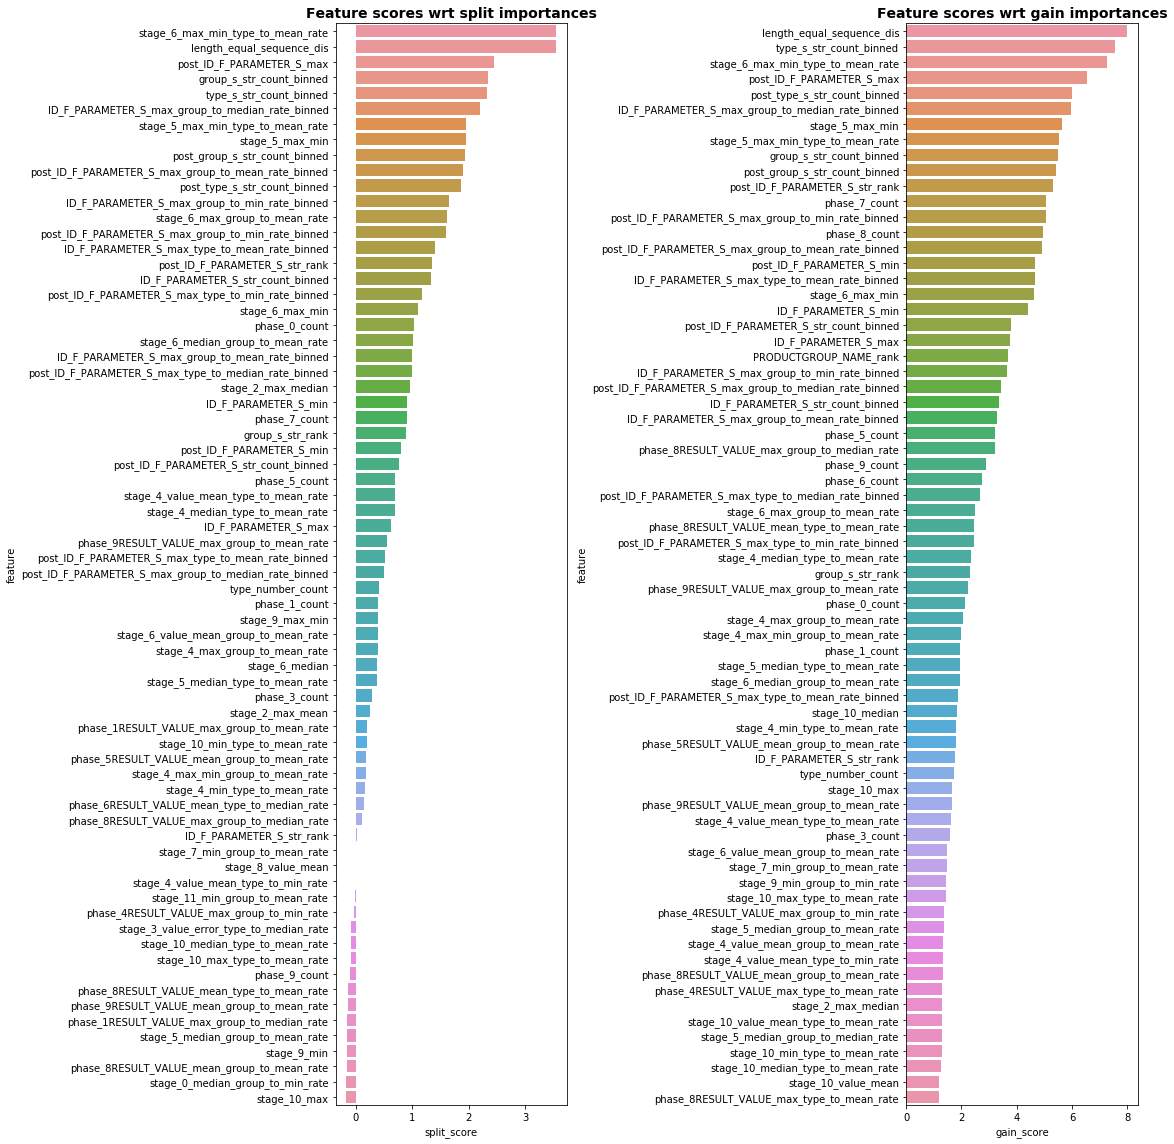

In [174]:
left_percent = 90
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, left_percent)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, left_percent)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [175]:
drop_cols = scores_df[scores_df.split_score<0]['feature'].values.tolist()
len(drop_cols)

728

In [176]:
#drop_cols = []#corred_cols
features = [x for x in train_3.columns if x not in list(set(['product_id','target','pred','PRODUCTGROUP_NAME','type_number',\
                                                            "type_s_str","ID_F_PARAMETER_S_str","group_s_str"])|set(drop_cols))]
#features = [x for x in train_3.columns if x not in list(set(['product_id','target','pred'])|set(drop_cols))]
target = 'target'
len(features)

19

In [177]:
params = {
    'n_estimators': 5000,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'n_thread':4,
    'early_stopping_rounds': 100,
}

In [178]:
train_3 = train_3[~np.isnan(train_3.target)]

In [179]:
fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
X = train_3[features].copy()
y = train_3[target]
models = []
pred = np.zeros(len(test_3),)
oof = np.zeros(len(train_3),)
seed_everything(42)
#for index,(train_idx,val_idx) in enumerate(fold.split(X,train_3["type_number"])):
for index,(train_idx,val_idx) in enumerate(fold.split(X,y)):
    train_set = lgb.Dataset(X.iloc[train_idx],y.iloc[train_idx]-1)
    val_set = lgb.Dataset(X.iloc[val_idx],y.iloc[val_idx]-1)
    #print(Counter(y.iloc[val_idx]))
    model = lgb.train(params,train_set,valid_sets=[train_set,val_set],verbose_eval=100)
    models.append(model)
    val_pred = model.predict(X.iloc[val_idx])
    oof[val_idx] = val_pred
    val_y = y.iloc[val_idx]
    val_pred = val_pred>0.5
    print(index,'val f1',metrics.f1_score(val_y-1,val_pred))
    test_pred = model.predict(test_3[features])
    pred+=test_pred/5
    
oof = oof>0.5
print("oof f1",metrics.f1_score(oof,y-1))

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0346648	valid_1's binary_logloss: 0.0843927
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.050433	valid_1's binary_logloss: 0.0806156
0 val f1 0.7183673469387756
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0334923	valid_1's binary_logloss: 0.0919084
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0576827	valid_1's binary_logloss: 0.085192
1 val f1 0.7020408163265305
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0327404	valid_1's binary_logloss: 0.0898591
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0569703	valid_1's binary_logloss: 0.0839168
2 val f1 0.6748971193415638
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0327482	valid_1's binary_logloss: 0.0992029
Early stopping,

In [180]:
train_3["pred"] = oof.astype(float)+1
train_3["pred"].value_counts(normalize=True)

1.0    0.969725
2.0    0.030275
Name: pred, dtype: float64

In [181]:
train_3.drop(["pred"],axis=1,inplace=True)

In [182]:
phase_3_results = (pred>0.5).astype(np.int32)+1
phase_3_results = pd.DataFrame({
    "id":test_3["product_id"],
    "label":phase_3_results
})

In [183]:
phase_3_results["label"].value_counts(normalize=True)

1    0.97656
2    0.02344
Name: label, dtype: float64

In [184]:
phase_s_results = pd.concat([phase_3_results,
          pd.DataFrame({
              'id':list(answer_map.keys()),
              'label':list(answer_map.values()),
          })]).reset_index(drop=True)

In [185]:
phase_s_results["label"].value_counts(normalize=True)

1    0.980919
2    0.019081
Name: label, dtype: float64

In [186]:
ret = []
for index, model in enumerate(models):
    df = pd.DataFrame()
    df['name'] = model.feature_name()
    df['score'] = model.feature_importance()
    df['fold'] = index
    ret.append(df)
    
df = pd.concat(ret)
df = df.groupby('name', as_index=False)['score'].mean()
df = df.sort_values(['score'], ascending=False)
df

,name,score
13,phase_1RESULT_VALUE_max_group_to_mean_rate,285.4
15,stage_2_max_mean,186.4
16,stage_2_max_median,87.4
10,group_s_str_rank,79.8
17,type_number_count,77.4
18,type_s_str_count_binned,76.6
5,ID_F_PARAMETER_S_max_type_to_median_rate_binned,50.0
6,ID_F_PARAMETER_S_min,48.8
4,ID_F_PARAMETER_S_max_type_to_mean_rate_binned,42.6
8,ID_F_PARAMETER_S_str_rank,35.2


***adversial validation***

In [207]:
drop_cols = []
train_3["target"] = 0
test_3["target"] = 1
data = pd.concat([train_3,test_3]).reset_index(drop=True)

features = [x for x in train_3.columns if x not in ['product_id','target','pred','PRODUCTGROUP_NAME','type_number']]
features = list(set(features)-set(drop_cols))
print(len(features))

fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
X = data[features].copy()
y = data["target"]
models = []
oof = np.zeros(len(X),)
seed_everything(42)

for index,(train_idx,val_idx) in enumerate(fold.split(X,y)):
    train_set = lgb.Dataset(X.iloc[train_idx],y[train_idx])
    val_set = lgb.Dataset(X.iloc[val_idx],y[val_idx])
    #print(Counter(y[val_idx]))
    model = lgb.train(params,train_set,valid_sets=[train_set,val_set],verbose_eval=100)
    models.append(model)
    val_pred = model.predict(X.iloc[val_idx])
    oof[val_idx] = val_pred
    val_y = y[val_idx]
    print(index,'val f1',metrics.roc_auc_score(val_y,val_pred))
    
print("oof f1",metrics.roc_auc_score(y,oof))

8
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.315531	valid_1's binary_logloss: 0.318456
[200]	training's binary_logloss: 0.31545	valid_1's binary_logloss: 0.318004
[300]	training's binary_logloss: 0.315436	valid_1's binary_logloss: 0.317892
[400]	training's binary_logloss: 0.315431	valid_1's binary_logloss: 0.317862
[500]	training's binary_logloss: 0.315429	valid_1's binary_logloss: 0.317857
[600]	training's binary_logloss: 0.315428	valid_1's binary_logloss: 0.317855
[700]	training's binary_logloss: 0.315427	valid_1's binary_logloss: 0.317853
[800]	training's binary_logloss: 0.315426	valid_1's binary_logloss: 0.317853
[900]	training's binary_logloss: 0.315425	valid_1's binary_logloss: 0.317852
[1000]	training's binary_logloss: 0.315425	valid_1's binary_logloss: 0.317851
[1100]	training's binary_logloss: 0.315425	valid_1's binary_logloss: 0.317851
[1200]	training's binary_logloss: 0.315424	valid_1's binary_logloss: 0.31785
[1300]	trai

KeyboardInterrupt: 

In [203]:
ret = []
for index, model in enumerate(models):
    df = pd.DataFrame()
    df['name'] = model.feature_name()
    df['score'] = model.feature_importance()
    df['fold'] = index
    ret.append(df)
    
df = pd.concat(ret)
df = df.groupby('name', as_index=False)['score'].mean()
df = df.sort_values(['score'], ascending=False)
df

,name,score
7,phase_1ID_F_PARAMETER_S_max_group_to_mean_rate...,733.6
4,phase_0ID_F_PARAMETER_S_max_min,138.2
12,phase_1RESULT_VALUE_min,133.0
1,ID_F_PARAMETER_S_max_min_type_to_median_rate_b...,130.6
11,phase_1RESULT_VALUE_5p,123.2
9,phase_1ID_F_PARAMETER_S_max_min_group_to_mean_...,119.2
13,phase_1_count,118.0
2,PRODUCTGROUP_NAME_rank,111.6
17,process_length,100.8
18,stage_4_value_mean,96.8


*** feature engineering for 10_process ***

In [483]:
"""phase (UU9) features"""
compiled_train_10 = []
used_ids = []
for index_,(pro_id,user_sample) in tqdm(enumerate(train.groupby("Product_ID",sort=False)),total=len(train["Product_ID"].unique())):
    user_sample_pre = user_sample[user_sample.ID_F_PHASE_S<3]
    user_sample_pre = user_sample_pre.sort_values(["ID_F_PARAMETER_S","SIDE","AXIS"])
    user_sample_pre = user_sample_pre[user_sample_pre.ID_F_PHASE_S<2]
    user_sample_post = user_sample[(user_sample.ID_F_PHASE_S>3)&(user_sample.ID_F_PHASE_S<10)]
    if len(user_sample_pre)>10:
        index = 0
        feature = {}
        stage = None
        all_values = []
        values = []
        feature["product_id"] = pro_id
        for i,row in user_sample_pre.iterrows():
            if index>3:
                break
            if stage is None:
                stage = row["SIDE"]
            if stage==row["SIDE"]:
                values.append(row["RESULT_VALUE"])
            else:
                #print(values,index,np.mean(values))
                feature["stage_{}_value_mean".format(index)] = np.mean(values)
                feature["stage_{}_min".format(index)] = np.min(values)
                feature["stage_{}_value_error".format(index)] = np.sum([np.abs(value-np.mean(values)) for value in values])
                feature["stage_{}_median".format(index)] = np.median(values)
                feature["stage_{}_max_mean".format(index)] = np.max(values)-np.mean(values)
                feature["stage_{}_max_median".format(index)] = np.max(values)-np.median(values)
                all_values.append(values)
                values = []
                values.append(row["RESULT_VALUE"])
                stage = row["SIDE"]
                index+=1
        try:
            feature["stage_1-0_value_diff"] = feature["stage_1_value_mean"]-feature["stage_0_value_mean"]
        except:
            feature["stage_1-0_value_diff"] = 0
        try:
            feature["stage_3-2_value_diff"] = feature["stage_3_value_mean"]-feature["stage_2_value_mean"]
        except:
            feature["stage_3-2_value_diff"] = 0
        try:
            feature["stage_1-0_error_sum"] = np.sum([np.abs(x-y) for x,y in zip(all_values[1],all_values[0])])
        except:
            feature["stage_1-0_error_sum"] = 0
        try:
            feature["stage_3-2_error_sum"] = np.sum([np.abs(x-y) for x,y in zip(all_values[3],all_values[2])])
        except:
            feature["stage_3-2_error_sum"] = 0
        if len(user_sample_post)>3:
            index = 4
            for i,row in user_sample_post.iterrows():
                if stage is None:
                    stage = row["SIDE"]
                if stage==row["SIDE"]:
                    values.append(row["RESULT_VALUE"])
                else:
                    #print(values,index,np.mean(values))
                    feature["stage_{}_value_mean".format(index)] = np.mean(values)
                    feature["stage_{}_min".format(index)] = np.min(values)
                    feature["stage_{}_median".format(index)] = np.median(values)
                    feature["stage_{}_max_min".format(index)] = np.max(values)-np.min(values)
                    feature["stage_{}_max".format(index)] = np.max(values)
                    all_values.append(values)
                    values = []
                    values.append(row["RESULT_VALUE"])
                    stage = row["SIDE"]
                    index+=1
        compiled_train_10.append(pd.DataFrame(feature,index=[index_]))
train_10_1 = pd.concat(compiled_train_10)

100%|████████████████████████████████████████████████████████████████████████████| 17693/17693 [07:03<00:00, 41.79it/s]


In [484]:
used_ids = train_10_1["product_id"].unique().tolist()
len(used_ids),train_10_1.shape

(16252, (16252, 89))

In [485]:
for col in train_10_1:
    train_10_1[col].fillna(0,inplace=True)

In [486]:
compiled_train_10 = []
used_ids = train_10_1["product_id"].unique().tolist()
for i,(pro_id,user_sample) in tqdm(enumerate(train.groupby("Product_ID",sort=False)),total=len(train["Product_ID"].unique())):
    if pro_id in used_ids:
        user_sample = user_sample[user_sample.ID_F_PHASE_S<10]
        if len(user_sample)>10:
            compiled_train_10.append(pd.DataFrame(feature_extract(user_sample,phases=10,test_set=False),index=[i]))
train_10_2 = pd.concat(compiled_train_10)

100%|████████████████████████████████████████████████████████████████████████████| 17693/17693 [08:08<00:00, 36.20it/s]


In [489]:
train_10 = train_10_1.merge(train_10_2,on="product_id",how="left")

In [462]:
"""another kind of phase"""
compiled_test_10 = []
used_ids = []
for index_,(pro_id,user_sample) in tqdm(enumerate(test_11_part.groupby("Product_ID",sort=False)),total=len(test_11_part["Product_ID"].unique())):
    user_sample_pre = user_sample[user_sample.ID_F_PHASE_S<3]
    user_sample_pre = user_sample_pre.sort_values(["ID_F_PARAMETER_S","SIDE","AXIS"])
    user_sample_pre = user_sample_pre[user_sample_pre.ID_F_PHASE_S<2]
    user_sample_post = user_sample[(user_sample.ID_F_PHASE_S>3)&(user_sample.ID_F_PHASE_S<10)]
    if len(user_sample_pre)>10:
        index = 0
        feature = {}
        stage = None
        all_values = []
        values = []
        feature["product_id"] = pro_id
        for i,row in user_sample_pre.iterrows():
            if index>3:
                break
            if stage is None:
                stage = row["SIDE"]
            if stage==row["SIDE"]:
                values.append(row["RESULT_VALUE"])
            else:
                #print(values,index,np.mean(values))
                feature["stage_{}_value_mean".format(index)] = np.mean(values)
                feature["stage_{}_min".format(index)] = np.min(values)
                feature["stage_{}_value_error".format(index)] = np.sum([np.abs(value-np.mean(values)) for value in values])
                feature["stage_{}_median".format(index)] = np.median(values)
                feature["stage_{}_max_mean".format(index)] = np.max(values)-np.mean(values)
                feature["stage_{}_max_median".format(index)] = np.max(values)-np.median(values)
                all_values.append(values)
                values = []
                values.append(row["RESULT_VALUE"])
                stage = row["SIDE"]
                index+=1
        try:
            feature["stage_1-0_value_diff"] = feature["stage_1_value_mean"]-feature["stage_0_value_mean"]
        except:
            feature["stage_1-0_value_diff"] = 0
        try:
            feature["stage_3-2_value_diff"] = feature["stage_3_value_mean"]-feature["stage_2_value_mean"]
        except:
            feature["stage_3-2_value_diff"] = 0
        try:
            feature["stage_1-0_error_sum"] = np.sum([np.abs(x-y) for x,y in zip(all_values[1],all_values[0])])
        except:
            feature["stage_1-0_error_sum"] = 0
        try:
            feature["stage_3-2_error_sum"] = np.sum([np.abs(x-y) for x,y in zip(all_values[3],all_values[2])])
        except:
            feature["stage_3-2_error_sum"] = 0
        #compiled_train_10.append(pd.DataFrame(feature,index=[i]))
        used_ids.append(pro_id)
    if len(user_sample_post)>3:
        index = 4
        for i,row in user_sample_post.iterrows():
            if index>15:
                break
            if stage is None:
                stage = row["SIDE"]
            if stage==row["SIDE"]:
                values.append(row["RESULT_VALUE"])
            else:
                #print(values,index,np.mean(values))
                feature["stage_{}_value_mean".format(index)] = np.mean(values)
                feature["stage_{}_min".format(index)] = np.min(values)
                feature["stage_{}_median".format(index)] = np.median(values)
                feature["stage_{}_max_min".format(index)] = np.max(values)-np.min(values)
                feature["stage_{}_max".format(index)] = np.max(values)
                all_values.append(values)
                values = []
                values.append(row["RESULT_VALUE"])
                stage = row["SIDE"]
                index+=1
        compiled_test_10.append(pd.DataFrame(feature,index=[index_]))
test_10_1 = pd.concat(compiled_test_10)

100%|██████████████████████████████████████████████████████████████████████████████| 3285/3285 [01:50<00:00, 29.76it/s]


In [467]:
for col in test_10_1:
    test_10_1[col].fillna(0,inplace=True)

In [469]:
compiled_test_10 = []
dropped_ids = []
for i,(pro_id,user_sample) in tqdm(enumerate(test_11_part.groupby("Product_ID",sort=False)),total=len(test_11_part["Product_ID"].unique())):
    if pro_id in used_ids:
        user_sample = user_sample[user_sample.ID_F_PHASE_S<10]
        compiled_test_10.append(pd.DataFrame(feature_extract(user_sample,phases=10,test_set=True),index=[i]))
test_10_2 = pd.concat(compiled_test_10)

100%|██████████████████████████████████████████████████████████████████████████████| 3285/3285 [02:15<00:00, 24.16it/s]


In [491]:
test_10 = test_10_1.merge(test_10_2,on="product_id",how="left")

In [492]:
train_10.to_csv("./train_10_phase.csv",index=False)
test_10.to_csv("./test_10_phase.csv",index=False)

In [78]:
train_10 = pd.read_csv("./train_10_phase.csv")
test_10 = pd.read_csv("./test_10_phase.csv")

In [79]:
drop_cols = []
"""
for col in train_10:
    if ("_5p" in col or "_min" in col) and "stage" not in col and "ID_F_PARAMETER_S" not in col:
        drop_cols.append(col)
for col in train_10:
    if "value_error" in col:
        drop_cols.append(col)
for col in train_10:
    if "stage" in col:
        drop_cols.append(col)"""

'\nfor col in train_10:\n    if ("_5p" in col or "_min" in col) and "stage" not in col and "ID_F_PARAMETER_S" not in col:\n        drop_cols.append(col)\nfor col in train_10:\n    if "value_error" in col:\n        drop_cols.append(col)\nfor col in train_10:\n    if "stage" in col:\n        drop_cols.append(col)'

In [80]:
train_10.drop(drop_cols,axis=1,inplace=True)
test_10.drop(drop_cols,axis=1,inplace=True)

In [81]:
new_features = []
for col in train_10:
    if "stage" in col and "max_mean" not in col and "max_median" not in col:
        new_features.append(col)
        #print(col)
    if "RESULT_VALUE" in col and ("max" in col or "mean" in col):
        new_features.append(col)
        #print(col)
    if "ID_F_PARAMETER_S" in col and "max" in col:
        new_features.append(col)
        #print(col)

In [82]:
data = pd.concat([train_10,test_10])
data = group_statics(data,new_features)
data = type_statics(data,new_features)

In [83]:
for col in data:
    if data[col].dtype=="object" and col!='product_id':
        print(col)
        count_dict = data[col].value_counts().to_dict()
        data[col+"_count"] = data[col].apply(lambda x:count_dict[x])
        data[col+'_rank'] = data[col].transform("rank")
        #data.drop(col,axis=1,inplace=True)
        data[col] = data[col].astype("category")
train_10 = data.iloc[:len(train_10)]
test_10 = data.iloc[len(train_10):]

ID_F_PARAMETER_S_str
PRODUCTGROUP_NAME
group_s_str
post_ID_F_PARAMETER_S_str
post_group_s_str
post_type_s_str
type_number
type_s_str


In [84]:
seq_cols = ["ID_F_PARAMETER_S_str_count","post_ID_F_PARAMETER_S_str_count","type_s_str_count","post_type_s_str_count","post_group_s_str_count",\
            "group_s_str_count"]
for col in train_10:
    if ("_type_to" in col or "_group_to" in col) and "ID_F_PARAMETER_S" in col:
    #if train_3[col].dtype=="float64" and col!="target":
    #if "ID_F_PARAMETER_S" in col and ("min"in col or "max" in col or "max_min" in col):
        train_10[col].fillna(0,inplace=True)
        test_10[col].fillna(0,inplace=True)
        seq_cols.append(col)
train_10,test_10,_ = bin_encoding(train_10,test_10,seq_cols,bins=None)
train_10.drop(seq_cols,axis=1,inplace=True)
test_10.drop(seq_cols,axis=1,inplace=True)

ID_F_PARAMETER_S_max_type_to_median_rate


In [85]:
train_10.shape,test_10.shape

((16252, 791), (3285, 791))

*** modeling for 10_process ***

In [133]:
train_10 = train_10[~np.isnan(train_10.target)]
train_10 = train_10[train_10.target!=0]
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    imp_df = get_feature_importances(train=train_10,shuffle=True)
    imp_df['run'] = i+1
    null_imp_df = pd.concat([null_imp_df,imp_df],axis=0)
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    spent = (time.time()-start)/60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp,end='',flush=True)

Done with   80 of   80 (Spent  65.3 min)

In [137]:
actual_imp_df = get_feature_importances(train=train_10, shuffle=False)

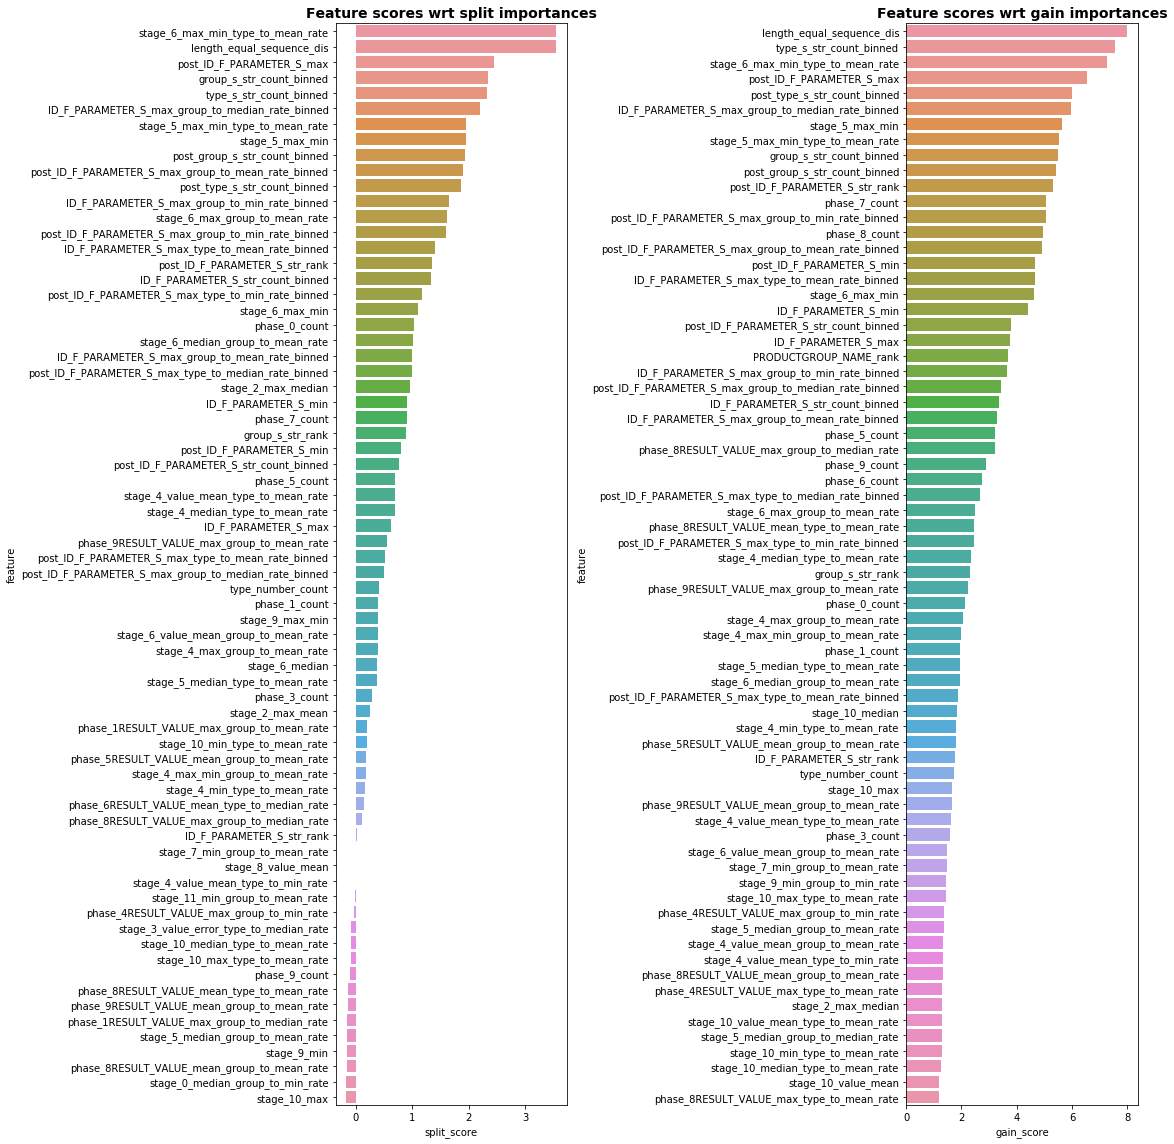

In [187]:
left_percent = 90
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, left_percent)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, left_percent)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [188]:
drop_cols = scores_df[scores_df.split_score<0]['feature'].values.tolist()
len(drop_cols)

728

In [189]:
#drop_cols = []
features = [x for x in train_10.columns if x not in list(set(['product_id','target','pred','PRODUCTGROUP_NAME','type_number',"post_group_s_str",\
                    "post_ID_F_PARAMETER_S_str","post_type_s_str","type_s_str","ID_F_PARAMETER_S_str","group_s_str"])|set(drop_cols))]
target = 'target'
len(features)

56

In [190]:
params = {
    'n_estimators': 5000,
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'n_thread':4,
    'early_stopping_rounds': 100,
}

In [191]:
train_10 = train_10[~np.isnan(train_10.target)]
train_10 = train_10[train_10.target!=0]

In [192]:
fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
X = train_10[features].copy()
y = train_10[target]
models = []
pred = np.zeros(len(test_10),)
oof = np.zeros(len(train_10),)

for index,(train_idx,val_idx) in enumerate(fold.split(X,y)):
    train_set = lgb.Dataset(X.iloc[train_idx],y.iloc[train_idx]-1)
    val_set = lgb.Dataset(X.iloc[val_idx],y.iloc[val_idx]-1)
    
    model = lgb.train(params,train_set,valid_sets=[train_set,val_set],verbose_eval=100)
    models.append(model)
    val_pred = model.predict(X.iloc[val_idx])
    oof[val_idx] = val_pred
    val_y = y.iloc[val_idx]
    val_pred = val_pred>0.5
    print(index,'val f1',metrics.f1_score(val_y-1,val_pred))
    test_pred = model.predict(test_10[features])
    pred+=test_pred/5
    
oof = oof>0.5
print("oof f1",metrics.f1_score(oof,y-1))

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0214074	valid_1's binary_logloss: 0.0692879
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0411865	valid_1's binary_logloss: 0.0671222
0 val f1 0.7667984189723319
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0195481	valid_1's binary_logloss: 0.093809
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0493868	valid_1's binary_logloss: 0.0848821
1 val f1 0.7040000000000001
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0200607	valid_1's binary_logloss: 0.0847087
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0458889	valid_1's binary_logloss: 0.0804511
2 val f1 0.7430830039525692
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.0179526	valid_1's binary_logloss: 0.099412
Early stopping,

In [193]:
train_10["pred"] = oof
train_10["pred"].value_counts(normalize=True)

False    0.967571
True     0.032429
Name: pred, dtype: float64

In [194]:
train_10.drop(["pred"],axis=1,inplace=True)

In [195]:
phase_10_results = (pred>0.5).astype(np.int32)+1
phase_10_results = pd.DataFrame({
    "id":test_10["product_id"],
    "label":phase_10_results
})

In [196]:
phase_10_results["label"].value_counts(normalize=True)

1    0.977778
2    0.022222
Name: label, dtype: float64

In [197]:
phase_10_results = pd.concat([phase_10_results,
          pd.DataFrame({
              'id':list(answer_map_.keys()),
              'label':list(answer_map_.values()),
          })]).reset_index(drop=True)

In [198]:
phase_10_results["label"].value_counts(normalize=True)

1    0.980708
2    0.019292
Name: label, dtype: float64

In [199]:
ret = []
for index, model in enumerate(models):
    df = pd.DataFrame()
    df['name'] = model.feature_name()
    df['score'] = model.feature_importance()
    df['fold'] = index
    ret.append(df)
    
df = pd.concat(ret)
df = df.groupby('name', as_index=False)['score'].mean()
df = df.sort_values(['score'], ascending=False)
df

,name,score
12,phase_1RESULT_VALUE_max_group_to_mean_rate,114.0
34,stage_2_max_mean,87.8
17,phase_6RESULT_VALUE_mean_type_to_median_rate,72.2
19,phase_8RESULT_VALUE_max_group_to_median_rate,54.6
44,stage_5_median_type_to_mean_rate,51.2
52,stage_8_value_mean,49.6
35,stage_2_max_median,44.6
20,phase_9RESULT_VALUE_max_group_to_mean_rate,40.8
55,type_s_str_count_binned,35.4
32,post_type_s_str_count_binned,34.2


## making submission

In [200]:
sample = pd.concat([phase_s_results,phase_10_results]).reset_index(drop=True)

In [201]:
sample.to_csv("./INSPEC_result.csv",index=False)

In [204]:
sample["label"].value_counts(normalize=True)

1    0.980813
2    0.019187
Name: label, dtype: float64

In [203]:
sample.shape

(7505, 2)